## Work
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

# Hint 1 : 在 Dense 層中增加 Regularizers

In [5]:
from keras.regularizers import l1_l2
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
"""
Set your hyper-parameters
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

In [7]:
results = {}
"""
Set your training loop
"""
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with L1 = 0.010000, L2 = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=============

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 117us/step - loss: 198.7438 - acc: 0.2361 - val_loss: 41.1770 - val_acc: 0.2547
Epoch 2/50
50000/50000 [==============================] - 5s 106us/step - loss: 19.1515 - acc: 0.1192 - val_loss: 7.2906 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 5s 105us/step - loss: 4.1192 - acc: 0.0966 - val_loss: 2.6513 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 5s 105us/step - loss: 2.4869 - acc: 0.0986 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 5s 105us/step - loss: 2.4626 - acc: 0.0988 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 5s 106us/step - loss: 2.4626 - acc: 0.0978 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 5s 105us/step - loss: 2.4626 - acc: 0.0964 - val_loss: 2.462

Epoch 2/50
50000/50000 [==============================] - 6s 124us/step - loss: 19.1117 - acc: 0.1193 - val_loss: 7.2848 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 8s 160us/step - loss: 4.1209 - acc: 0.0992 - val_loss: 2.6523 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 7s 137us/step - loss: 2.4866 - acc: 0.0979 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 8s 161us/step - loss: 2.4626 - acc: 0.0996 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 8s 163us/step - loss: 2.4626 - acc: 0.1000 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 8s 165us/step - loss: 2.4626 - acc: 0.0986 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 8s 165us/step - loss: 2.4626 - acc: 0.0988 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 9/50
50000/50000 [=========

50000/50000 [==============================] - 8s 169us/step - loss: 4.1200 - acc: 0.0996 - val_loss: 2.6545 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 9s 176us/step - loss: 2.4872 - acc: 0.0979 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 8s 170us/step - loss: 2.4626 - acc: 0.0970 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 9s 171us/step - loss: 2.4626 - acc: 0.0986 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 9s 170us/step - loss: 2.4626 - acc: 0.0982 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 9s 170us/step - loss: 2.4626 - acc: 0.0965 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 8s 170us/step - loss: 2.4626 - acc: 0.0966 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 10/50
50000/50000 [====================

50000/50000 [==============================] - 5s 105us/step - loss: 2.4881 - acc: 0.0970 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 5s 103us/step - loss: 2.4626 - acc: 0.0984 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.4626 - acc: 0.0980 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.4626 - acc: 0.0987 - val_loss: 2.4623 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.4626 - acc: 0.0971 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.4626 - acc: 0.0986 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 10/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.4626 - acc: 0.0973 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 11/50
50000/50000 [===================

50000/50000 [==============================] - 8s 169us/step - loss: 10.5465 - acc: 0.4042 - val_loss: 9.8376 - val_acc: 0.4091
Epoch 6/50
50000/50000 [==============================] - 8s 166us/step - loss: 9.2073 - acc: 0.4113 - val_loss: 8.6094 - val_acc: 0.4080
Epoch 7/50
50000/50000 [==============================] - 8s 160us/step - loss: 8.0663 - acc: 0.4177 - val_loss: 7.5504 - val_acc: 0.4199
Epoch 8/50
50000/50000 [==============================] - 8s 169us/step - loss: 7.0953 - acc: 0.4210 - val_loss: 6.6573 - val_acc: 0.4166
Epoch 9/50
50000/50000 [==============================] - 8s 169us/step - loss: 6.2660 - acc: 0.4259 - val_loss: 5.9027 - val_acc: 0.4270
Epoch 10/50
50000/50000 [==============================] - 10s 190us/step - loss: 5.5615 - acc: 0.4316 - val_loss: 5.2676 - val_acc: 0.4175
Epoch 11/50
50000/50000 [==============================] - 9s 188us/step - loss: 4.9619 - acc: 0.4353 - val_loss: 4.6969 - val_acc: 0.4319
Epoch 12/50
50000/50000 [================

50000/50000 [==============================] - 5s 107us/step - loss: 5.3370 - acc: 0.4460 - val_loss: 5.3103 - val_acc: 0.4400
Epoch 7/50
50000/50000 [==============================] - 5s 106us/step - loss: 5.2386 - acc: 0.4585 - val_loss: 5.2039 - val_acc: 0.4531
Epoch 8/50
50000/50000 [==============================] - 5s 108us/step - loss: 5.1447 - acc: 0.4652 - val_loss: 5.1251 - val_acc: 0.4562
Epoch 9/50
50000/50000 [==============================] - 5s 107us/step - loss: 5.0534 - acc: 0.4766 - val_loss: 5.0340 - val_acc: 0.4628
Epoch 10/50
50000/50000 [==============================] - 5s 107us/step - loss: 4.9651 - acc: 0.4836 - val_loss: 4.9515 - val_acc: 0.4706
Epoch 11/50
50000/50000 [==============================] - 5s 108us/step - loss: 4.8792 - acc: 0.4900 - val_loss: 4.8771 - val_acc: 0.4733
Epoch 12/50
50000/50000 [==============================] - 5s 107us/step - loss: 4.7930 - acc: 0.4999 - val_loss: 4.7950 - val_acc: 0.4861
Epoch 13/50
50000/50000 [=================

50000/50000 [==============================] - 5s 105us/step - loss: 5.1517 - acc: 0.4538 - val_loss: 5.1231 - val_acc: 0.4467
Epoch 8/50
50000/50000 [==============================] - 5s 104us/step - loss: 5.0622 - acc: 0.4638 - val_loss: 5.0364 - val_acc: 0.4584
Epoch 9/50
50000/50000 [==============================] - 5s 104us/step - loss: 4.9759 - acc: 0.4708 - val_loss: 4.9652 - val_acc: 0.4592
Epoch 10/50
50000/50000 [==============================] - 5s 105us/step - loss: 4.8914 - acc: 0.4782 - val_loss: 4.8772 - val_acc: 0.4722
Epoch 11/50
50000/50000 [==============================] - 5s 104us/step - loss: 4.8096 - acc: 0.4865 - val_loss: 4.8068 - val_acc: 0.4742
Epoch 12/50
50000/50000 [==============================] - 5s 104us/step - loss: 4.7283 - acc: 0.4941 - val_loss: 4.7261 - val_acc: 0.4779
Epoch 13/50
50000/50000 [==============================] - 5s 104us/step - loss: 4.6504 - acc: 0.5018 - val_loss: 4.6621 - val_acc: 0.4830
Epoch 14/50
50000/50000 [================

50000/50000 [==============================] - 5s 108us/step - loss: 5.0606 - acc: 0.4666 - val_loss: 5.0329 - val_acc: 0.4696
Epoch 9/50
50000/50000 [==============================] - 5s 105us/step - loss: 4.9764 - acc: 0.4734 - val_loss: 4.9635 - val_acc: 0.4623
Epoch 10/50
50000/50000 [==============================] - 5s 105us/step - loss: 4.8927 - acc: 0.4812 - val_loss: 4.8901 - val_acc: 0.4718
Epoch 11/50
50000/50000 [==============================] - 5s 104us/step - loss: 4.8102 - acc: 0.4889 - val_loss: 4.8135 - val_acc: 0.4720
Epoch 12/50
50000/50000 [==============================] - 5s 104us/step - loss: 4.7299 - acc: 0.4964 - val_loss: 4.7383 - val_acc: 0.4798
Epoch 13/50
50000/50000 [==============================] - 5s 104us/step - loss: 4.6523 - acc: 0.5023 - val_loss: 4.6615 - val_acc: 0.4812
Epoch 14/50
50000/50000 [==============================] - 5s 105us/step - loss: 4.5774 - acc: 0.5085 - val_loss: 4.6319 - val_acc: 0.4784
Epoch 15/50
50000/50000 [===============

50000/50000 [==============================] - 9s 173us/step - loss: 4.9731 - acc: 0.4728 - val_loss: 4.9504 - val_acc: 0.4677
Epoch 10/50
50000/50000 [==============================] - 9s 181us/step - loss: 4.8884 - acc: 0.4828 - val_loss: 4.8728 - val_acc: 0.4691
Epoch 11/50
50000/50000 [==============================] - 9s 179us/step - loss: 4.8063 - acc: 0.4894 - val_loss: 4.8187 - val_acc: 0.4676
Epoch 12/50
50000/50000 [==============================] - 10s 195us/step - loss: 4.7268 - acc: 0.4951 - val_loss: 4.7318 - val_acc: 0.4766
Epoch 13/50
50000/50000 [==============================] - 8s 170us/step - loss: 4.6499 - acc: 0.5027 - val_loss: 4.6515 - val_acc: 0.4867
Epoch 14/50
50000/50000 [==============================] - 9s 180us/step - loss: 4.5755 - acc: 0.5066 - val_loss: 4.6231 - val_acc: 0.4730
Epoch 15/50
50000/50000 [==============================] - 8s 162us/step - loss: 4.4998 - acc: 0.5149 - val_loss: 4.5401 - val_acc: 0.4770
Epoch 16/50
50000/50000 [=============

50000/50000 [==============================] - 5s 108us/step - loss: 4.9018 - acc: 0.4395 - val_loss: 4.6633 - val_acc: 0.4309
Epoch 11/50
50000/50000 [==============================] - 5s 105us/step - loss: 4.4379 - acc: 0.4427 - val_loss: 4.2348 - val_acc: 0.4450
Epoch 12/50
50000/50000 [==============================] - 5s 105us/step - loss: 4.0404 - acc: 0.4478 - val_loss: 3.8707 - val_acc: 0.4448
Epoch 13/50
50000/50000 [==============================] - 5s 109us/step - loss: 3.7011 - acc: 0.4498 - val_loss: 3.5489 - val_acc: 0.4538
Epoch 14/50
50000/50000 [==============================] - 5s 105us/step - loss: 3.4094 - acc: 0.4549 - val_loss: 3.2870 - val_acc: 0.4492
Epoch 15/50
50000/50000 [==============================] - 5s 105us/step - loss: 3.1592 - acc: 0.4589 - val_loss: 3.0502 - val_acc: 0.4593
Epoch 16/50
50000/50000 [==============================] - 5s 108us/step - loss: 2.9461 - acc: 0.4622 - val_loss: 2.8548 - val_acc: 0.4577
Epoch 17/50
50000/50000 [==============

50000/50000 [==============================] - 8s 165us/step - loss: 1.5735 - acc: 0.4936 - val_loss: 1.6361 - val_acc: 0.4748
Epoch 12/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.5501 - acc: 0.5027 - val_loss: 1.5953 - val_acc: 0.4846
Epoch 13/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.5309 - acc: 0.5083 - val_loss: 1.5706 - val_acc: 0.4932
Epoch 14/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.5103 - acc: 0.5181 - val_loss: 1.5967 - val_acc: 0.4748
Epoch 15/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.4916 - acc: 0.5251 - val_loss: 1.5829 - val_acc: 0.4802
Epoch 16/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.4747 - acc: 0.5295 - val_loss: 1.5583 - val_acc: 0.4913
Epoch 17/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.4561 - acc: 0.5357 - val_loss: 1.5340 - val_acc: 0.5053
Epoch 18/50
50000/50000 [==============

50000/50000 [==============================] - 8s 168us/step - loss: 1.4110 - acc: 0.5020 - val_loss: 1.4517 - val_acc: 0.4833
Epoch 13/50
50000/50000 [==============================] - 9s 171us/step - loss: 1.3877 - acc: 0.5117 - val_loss: 1.4495 - val_acc: 0.4818
Epoch 14/50
50000/50000 [==============================] - 9s 170us/step - loss: 1.3684 - acc: 0.5180 - val_loss: 1.4307 - val_acc: 0.4944
Epoch 15/50
50000/50000 [==============================] - 8s 169us/step - loss: 1.3485 - acc: 0.5255 - val_loss: 1.4258 - val_acc: 0.4907
Epoch 16/50
50000/50000 [==============================] - 9s 172us/step - loss: 1.3297 - acc: 0.5315 - val_loss: 1.4132 - val_acc: 0.4975
Epoch 17/50
50000/50000 [==============================] - 9s 170us/step - loss: 1.3132 - acc: 0.5370 - val_loss: 1.4141 - val_acc: 0.4998
Epoch 18/50
50000/50000 [==============================] - 8s 169us/step - loss: 1.2953 - acc: 0.5439 - val_loss: 1.3830 - val_acc: 0.5104
Epoch 19/50
50000/50000 [==============

50000/50000 [==============================] - 5s 104us/step - loss: 1.3966 - acc: 0.5074 - val_loss: 1.4685 - val_acc: 0.4761
Epoch 14/50
50000/50000 [==============================] - 5s 105us/step - loss: 1.3736 - acc: 0.5180 - val_loss: 1.4345 - val_acc: 0.4899
Epoch 15/50
50000/50000 [==============================] - 5s 105us/step - loss: 1.3560 - acc: 0.5236 - val_loss: 1.4632 - val_acc: 0.4834
Epoch 16/50
50000/50000 [==============================] - 5s 104us/step - loss: 1.3374 - acc: 0.5299 - val_loss: 1.4561 - val_acc: 0.4849
Epoch 17/50
50000/50000 [==============================] - 5s 105us/step - loss: 1.3195 - acc: 0.5351 - val_loss: 1.3956 - val_acc: 0.5035
Epoch 18/50
50000/50000 [==============================] - 5s 104us/step - loss: 1.3024 - acc: 0.5426 - val_loss: 1.4222 - val_acc: 0.4870
Epoch 19/50
50000/50000 [==============================] - 5s 104us/step - loss: 1.2847 - acc: 0.5488 - val_loss: 1.4289 - val_acc: 0.4906
Epoch 20/50
50000/50000 [==============

50000/50000 [==============================] - 5s 106us/step - loss: 1.3619 - acc: 0.5227 - val_loss: 1.4310 - val_acc: 0.4937
Epoch 15/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.3423 - acc: 0.5283 - val_loss: 1.4205 - val_acc: 0.4952
Epoch 16/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.3246 - acc: 0.5348 - val_loss: 1.4015 - val_acc: 0.5006
Epoch 17/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.3061 - acc: 0.5414 - val_loss: 1.4129 - val_acc: 0.5032
Epoch 18/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.2882 - acc: 0.5469 - val_loss: 1.4069 - val_acc: 0.5003
Epoch 19/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.2730 - acc: 0.5523 - val_loss: 1.4030 - val_acc: 0.5017
Epoch 20/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.2590 - acc: 0.5561 - val_loss: 1.4021 - val_acc: 0.5025
Epoch 21/50
50000/50000 [==============

50000/50000 [==============================] - 5s 107us/step - loss: 3.1702 - acc: 0.4588 - val_loss: 3.0622 - val_acc: 0.4569
Epoch 16/50
50000/50000 [==============================] - 5s 107us/step - loss: 2.9565 - acc: 0.4614 - val_loss: 2.8683 - val_acc: 0.4577
Epoch 17/50
50000/50000 [==============================] - 5s 107us/step - loss: 2.7727 - acc: 0.4638 - val_loss: 2.7022 - val_acc: 0.45777821
Epoch 18/50
50000/50000 [==============================] - 5s 109us/step - loss: 2.6146 - acc: 0.4685 - val_loss: 2.5542 - val_acc: 0.4631
Epoch 19/50
50000/50000 [==============================] - 5s 108us/step - loss: 2.4793 - acc: 0.4710 - val_loss: 2.4436 - val_acc: 0.4562
Epoch 20/50
50000/50000 [==============================] - 5s 107us/step - loss: 2.3631 - acc: 0.4729 - val_loss: 2.3385 - val_acc: 0.4636
Epoch 21/50
50000/50000 [==============================] - 5s 108us/step - loss: 2.2637 - acc: 0.4757 - val_loss: 2.2570 - val_acc: 0.4606
Epoch 22/50
50000/50000 [==========

50000/50000 [==============================] - 5s 108us/step - loss: 1.4605 - acc: 0.5353 - val_loss: 1.5379 - val_acc: 0.5029
Epoch 17/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.4425 - acc: 0.5409 - val_loss: 1.5572 - val_acc: 0.4935
Epoch 18/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.4269 - acc: 0.5473 - val_loss: 1.5339 - val_acc: 0.5070
Epoch 19/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.4107 - acc: 0.5538 - val_loss: 1.5254 - val_acc: 0.5066
Epoch 20/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.3933 - acc: 0.5590 - val_loss: 1.5427 - val_acc: 0.4972
Epoch 21/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.3798 - acc: 0.5629 - val_loss: 1.5005 - val_acc: 0.5125
Epoch 22/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.3663 - acc: 0.5690 - val_loss: 1.6254 - val_acc: 0.4818
Epoch 23/50
50000/50000 [==============

50000/50000 [==============================] - 6s 114us/step - loss: 1.3143 - acc: 0.5375 - val_loss: 1.3877 - val_acc: 0.5084
Epoch 18/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.2977 - acc: 0.5451 - val_loss: 1.4046 - val_acc: 0.4986
Epoch 19/50
50000/50000 [==============================] - 6s 113us/step - loss: 1.2795 - acc: 0.5513 - val_loss: 1.4005 - val_acc: 0.5016
Epoch 20/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.2645 - acc: 0.5547 - val_loss: 1.3790 - val_acc: 0.5148
Epoch 21/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.2488 - acc: 0.5609 - val_loss: 1.3889 - val_acc: 0.5077
Epoch 22/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.2312 - acc: 0.5668 - val_loss: 1.3871 - val_acc: 0.5104
Epoch 23/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.2177 - acc: 0.5713 - val_loss: 1.3612 - val_acc: 0.5162
Epoch 24/50
50000/50000 [==============

50000/50000 [==============================] - 5s 107us/step - loss: 1.3047 - acc: 0.5398 - val_loss: 1.3840 - val_acc: 0.5091
Epoch 19/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.2868 - acc: 0.5458 - val_loss: 1.3889 - val_acc: 0.5074
Epoch 20/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.2687 - acc: 0.5516 - val_loss: 1.3709 - val_acc: 0.5164
Epoch 21/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.2546 - acc: 0.5576 - val_loss: 1.3781 - val_acc: 0.5192
Epoch 22/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.2377 - acc: 0.5648 - val_loss: 1.4418 - val_acc: 0.4927
Epoch 23/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.2236 - acc: 0.5677 - val_loss: 1.4152 - val_acc: 0.5013
Epoch 24/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.2088 - acc: 0.5729 - val_loss: 1.3879 - val_acc: 0.5107
Epoch 25/50
50000/50000 [==============

50000/50000 [==============================] - 5s 108us/step - loss: 1.2798 - acc: 0.5495 - val_loss: 1.3914 - val_acc: 0.5092
Epoch 20/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.2642 - acc: 0.5551 - val_loss: 1.3721 - val_acc: 0.5120
Epoch 21/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.2462 - acc: 0.5631 - val_loss: 1.3615 - val_acc: 0.5092
Epoch 22/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.2315 - acc: 0.5678 - val_loss: 1.3859 - val_acc: 0.5043
Epoch 23/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.2177 - acc: 0.5725 - val_loss: 1.4132 - val_acc: 0.4981
Epoch 24/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.2038 - acc: 0.5786 - val_loss: 1.3741 - val_acc: 0.5133
Epoch 25/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.1871 - acc: 0.5842 - val_loss: 1.4053 - val_acc: 0.5021
Epoch 26/50
50000/50000 [==============

50000/50000 [==============================] - 5s 103us/step - loss: 2.3648 - acc: 0.4705 - val_loss: 2.3450 - val_acc: 0.4537
Epoch 21/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.2649 - acc: 0.4732 - val_loss: 2.2463 - val_acc: 0.4638
Epoch 22/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.1803 - acc: 0.4743 - val_loss: 2.1646 - val_acc: 0.4678
Epoch 23/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.1043 - acc: 0.4795 - val_loss: 2.1044 - val_acc: 0.4645
Epoch 24/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.0415 - acc: 0.4808 - val_loss: 2.0365 - val_acc: 0.4755
Epoch 25/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.9876 - acc: 0.4821 - val_loss: 1.9838 - val_acc: 0.4762
Epoch 26/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.9396 - acc: 0.4835 - val_loss: 1.9453 - val_acc: 0.4750
Epoch 27/50
50000/50000 [==============

50000/50000 [==============================] - 5s 103us/step - loss: 1.3952 - acc: 0.5567 - val_loss: 1.5122 - val_acc: 0.5130
Epoch 22/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.3787 - acc: 0.5636 - val_loss: 1.5074 - val_acc: 0.5151
Epoch 23/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.3676 - acc: 0.5684 - val_loss: 1.5286 - val_acc: 0.5102
Epoch 24/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.3540 - acc: 0.5720 - val_loss: 1.5010 - val_acc: 0.5201
Epoch 25/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.3348 - acc: 0.5816 - val_loss: 1.5071 - val_acc: 0.5167
Epoch 26/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.3231 - acc: 0.5837 - val_loss: 1.4965 - val_acc: 0.5228
Epoch 27/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.3083 - acc: 0.5897 - val_loss: 1.4970 - val_acc: 0.5178
Epoch 28/50
50000/50000 [==============

50000/50000 [==============================] - 5s 103us/step - loss: 1.2302 - acc: 0.5678 - val_loss: 1.4258 - val_acc: 0.4907
Epoch 23/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.2163 - acc: 0.5725 - val_loss: 1.3717 - val_acc: 0.5173
Epoch 24/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.2037 - acc: 0.5749 - val_loss: 1.4023 - val_acc: 0.5008
Epoch 25/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.1894 - acc: 0.5818 - val_loss: 1.3742 - val_acc: 0.5192
Epoch 26/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.1716 - acc: 0.5871 - val_loss: 1.3577 - val_acc: 0.5143
Epoch 27/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.1576 - acc: 0.5933 - val_loss: 1.3687 - val_acc: 0.5240
Epoch 28/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.1467 - acc: 0.5983 - val_loss: 1.3480 - val_acc: 0.5244
Epoch 29/50
50000/50000 [==============

50000/50000 [==============================] - 5s 103us/step - loss: 1.2156 - acc: 0.5713 - val_loss: 1.3742 - val_acc: 0.5175
Epoch 24/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.2020 - acc: 0.5763 - val_loss: 1.3775 - val_acc: 0.5158
Epoch 25/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.1863 - acc: 0.5824 - val_loss: 1.3703 - val_acc: 0.5133
Epoch 26/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.1718 - acc: 0.5900 - val_loss: 1.3516 - val_acc: 0.5212
Epoch 27/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.1573 - acc: 0.5934 - val_loss: 1.3650 - val_acc: 0.5205
Epoch 28/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.1443 - acc: 0.5963 - val_loss: 1.3415 - val_acc: 0.5261
Epoch 29/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.1307 - acc: 0.6021 - val_loss: 1.3520 - val_acc: 0.5234
Epoch 30/50
50000/50000 [==============

50000/50000 [==============================] - 4s 78us/step - loss: 1.2012 - acc: 0.5790 - val_loss: 1.4018 - val_acc: 0.5029
Epoch 25/50
50000/50000 [==============================] - 4s 78us/step - loss: 1.1861 - acc: 0.5848 - val_loss: 1.3674 - val_acc: 0.5125
Epoch 26/50
50000/50000 [==============================] - 4s 78us/step - loss: 1.1714 - acc: 0.5892 - val_loss: 1.3440 - val_acc: 0.5274
Epoch 27/50
50000/50000 [==============================] - 4s 77us/step - loss: 1.1573 - acc: 0.5940 - val_loss: 1.3648 - val_acc: 0.5190
Epoch 28/50
50000/50000 [==============================] - 4s 79us/step - loss: 1.1444 - acc: 0.5972 - val_loss: 1.3547 - val_acc: 0.5217
Epoch 29/50
50000/50000 [==============================] - 4s 78us/step - loss: 1.1318 - acc: 0.6025 - val_loss: 1.3764 - val_acc: 0.5137
Epoch 30/50
50000/50000 [==============================] - 4s 78us/step - loss: 1.1176 - acc: 0.6101 - val_loss: 1.3429 - val_acc: 0.5236
Epoch 31/50
50000/50000 [=====================

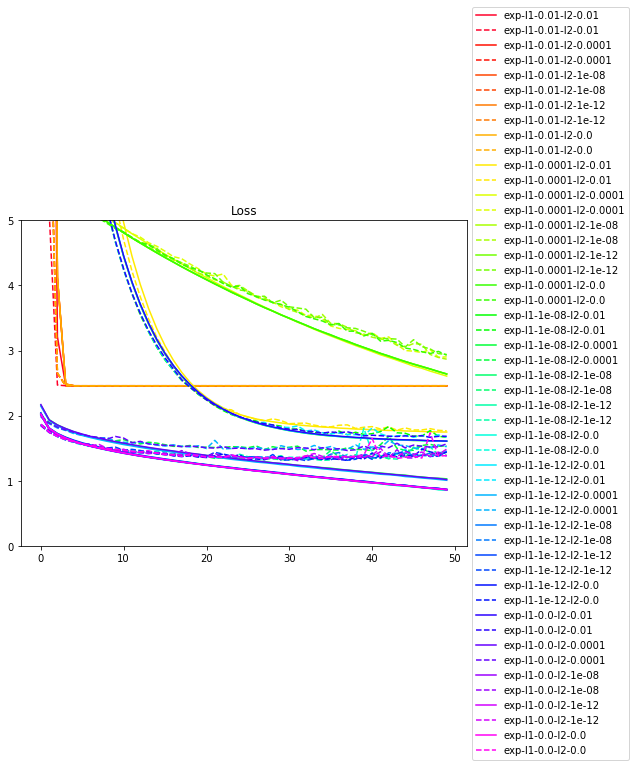

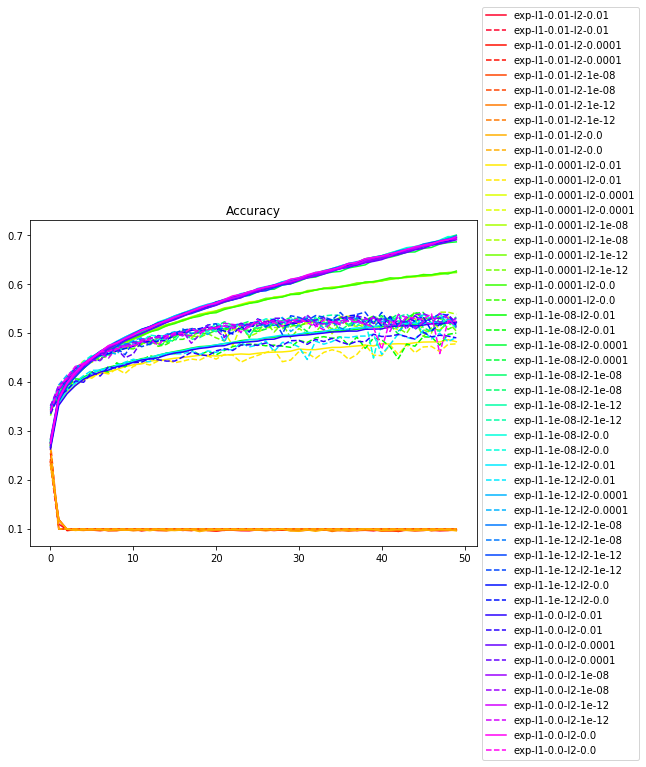

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""
plot the results
"""
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Hint 2 : 增加 Dropout 層並設定 dropout ratio 

In [9]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
## 超參數設定
"""
Set Hyper-parameters here
"""
LEARNING_RATE = 1e-4
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXP = 0.2

In [12]:
from keras.layers import Dropout
model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=Dropout_EXP)
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

Epoch 50/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.7261 - acc: 0.3856 - val_loss: 1.6490 - val_acc: 0.4212


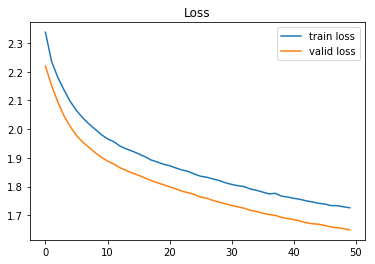

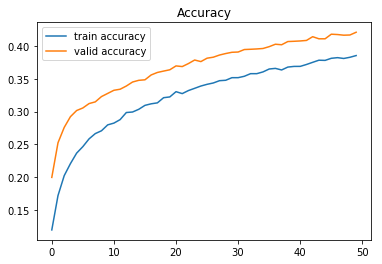

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

# Hint 3 : 增加 Batch-normalization 層

In [14]:
from keras.layers import BatchNormalization, Activation
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], pre_activate=False):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(input_layer)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(x)
            if pre_activate:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
            else:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [15]:
## 超參數設定
"""
Set your hyper-parameters
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [2, 16, 32, 128]
MOMENTUM = 0.95

In [16]:
results = {}
"""
Write your training loop and record results
"""
for batch_size in BATCH_SIZE:
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch_size, 
              validation_data=(x_test, y_test),
              shuffle=True)
    
    # Collect results
    exp_name_tag = ("exp-%s" % (batch_size))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
__________

50000/50000 [==============================] - 261s 5ms/step - loss: 2.2850 - acc: 0.1294 - val_loss: 2.3014 - val_acc: 0.1285
Epoch 47/50
50000/50000 [==============================] - 251s 5ms/step - loss: 2.2860 - acc: 0.1282 - val_loss: 2.2959 - val_acc: 0.1401
Epoch 48/50
50000/50000 [==============================] - 249s 5ms/step - loss: 2.2865 - acc: 0.1289 - val_loss: 2.2820 - val_acc: 0.1384
Epoch 49/50
50000/50000 [==============================] - 249s 5ms/step - loss: 2.2865 - acc: 0.1269 - val_loss: 2.2918 - val_acc: 0.1152
Epoch 50/50
50000/50000 [==============================] - 249s 5ms/step - loss: 2.2853 - acc: 0.1291 - val_loss: 2.3025 - val_acc: 0.1212
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)             

50000/50000 [==============================] - 33s 656us/step - loss: 1.0932 - acc: 0.6113 - val_loss: 1.3800 - val_acc: 0.5168
Epoch 42/50
50000/50000 [==============================] - 33s 659us/step - loss: 1.0899 - acc: 0.6136 - val_loss: 1.3807 - val_acc: 0.5204
Epoch 43/50
50000/50000 [==============================] - 33s 656us/step - loss: 1.0783 - acc: 0.6160 - val_loss: 1.3548 - val_acc: 0.5398
Epoch 44/50
50000/50000 [==============================] - 33s 656us/step - loss: 1.0736 - acc: 0.6204 - val_loss: 1.3694 - val_acc: 0.5259
Epoch 45/50
50000/50000 [==============================] - 33s 656us/step - loss: 1.0667 - acc: 0.6202 - val_loss: 1.3848 - val_acc: 0.5197
Epoch 46/50
50000/50000 [==============================] - 33s 656us/step - loss: 1.0637 - acc: 0.6223 - val_loss: 1.4052 - val_acc: 0.5152
Epoch 47/50
50000/50000 [==============================] - 33s 655us/step - loss: 1.0597 - acc: 0.6238 - val_loss: 1.3621 - val_acc: 0.5261
Epoch 48/50
50000/50000 [=======

50000/50000 [==============================] - 19s 381us/step - loss: 0.8769 - acc: 0.6888 - val_loss: 1.4946 - val_acc: 0.5159
Epoch 37/50
50000/50000 [==============================] - 19s 382us/step - loss: 0.8620 - acc: 0.6920 - val_loss: 1.5091 - val_acc: 0.5128
Epoch 38/50
50000/50000 [==============================] - 19s 381us/step - loss: 0.8502 - acc: 0.6966 - val_loss: 1.5651 - val_acc: 0.4952
Epoch 39/50
50000/50000 [==============================] - 19s 381us/step - loss: 0.8417 - acc: 0.7001 - val_loss: 1.5324 - val_acc: 0.5149
Epoch 40/50
50000/50000 [==============================] - 19s 382us/step - loss: 0.8317 - acc: 0.7063 - val_loss: 1.5704 - val_acc: 0.4997
Epoch 41/50
50000/50000 [==============================] - 19s 382us/step - loss: 0.8242 - acc: 0.7050 - val_loss: 1.5586 - val_acc: 0.5041
Epoch 42/50
50000/50000 [==============================] - 19s 381us/step - loss: 0.8097 - acc: 0.7109 - val_loss: 1.5251 - val_acc: 0.5092
Epoch 43/50
50000/50000 [=======

Epoch 32/50
50000/50000 [==============================] - 7s 138us/step - loss: 0.5103 - acc: 0.8261 - val_loss: 1.9023 - val_acc: 0.4593
Epoch 33/50
50000/50000 [==============================] - 7s 138us/step - loss: 0.4802 - acc: 0.8395 - val_loss: 1.9229 - val_acc: 0.4589
Epoch 34/50
50000/50000 [==============================] - 7s 138us/step - loss: 0.4651 - acc: 0.8429 - val_loss: 1.9619 - val_acc: 0.4679
Epoch 35/50
50000/50000 [==============================] - 7s 137us/step - loss: 0.4555 - acc: 0.8451 - val_loss: 1.9510 - val_acc: 0.4726
Epoch 36/50
50000/50000 [==============================] - 7s 138us/step - loss: 0.4281 - acc: 0.8561 - val_loss: 1.9702 - val_acc: 0.4806
Epoch 37/50
50000/50000 [==============================] - 7s 138us/step - loss: 0.4180 - acc: 0.8602 - val_loss: 1.9271 - val_acc: 0.4829
Epoch 38/50
50000/50000 [==============================] - 7s 141us/step - loss: 0.4065 - acc: 0.8621 - val_loss: 2.1667 - val_acc: 0.4622
Epoch 39/50
50000/50000 [==

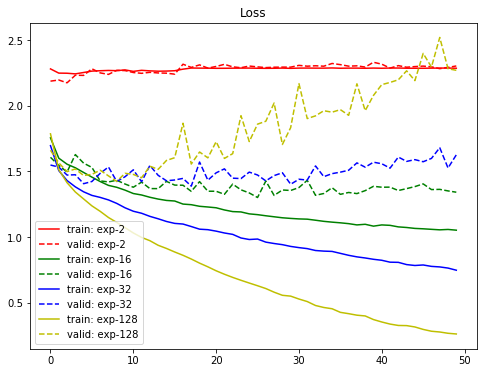

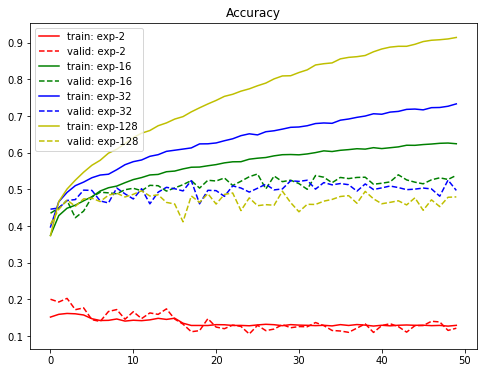

'\nPlot results\n'

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline

"""
Plot results
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=f"train: {cond}", color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=f"valid: {cond}", color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=f"train: {cond}", color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=f"valid: {cond}", color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()
"""
Plot results
"""